In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "/tmp/chapter10/"
CHAPTER_ID = "ann"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

Perceptrons

In [0]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:,(2,3)]
y = (iris.target==0).astype(np.int)

per_clf = Perceptron(max_iter=100, tol=-np.infty, random_state=42)
per_clf.fit(X,y)

y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([1])

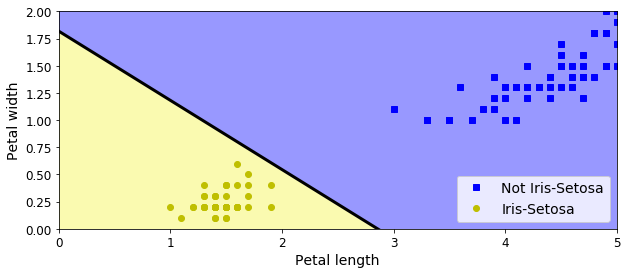

In [9]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ /per_clf.coef_[0][1]

axes = [0,5,0,2]

x0,x1= np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1,1),
    np.linspace(axes[2], axes[3], 200).reshape(-1,1),
)

X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

# save_fig("perceptron_iris_plot")
plt.show()

Activation functions

In [0]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def relu(z):
  return np.maximum(0,z)

def derivative(f,z,eps=0.0000001):
  return (f(z+eps) - f(z-eps))/(2*eps)

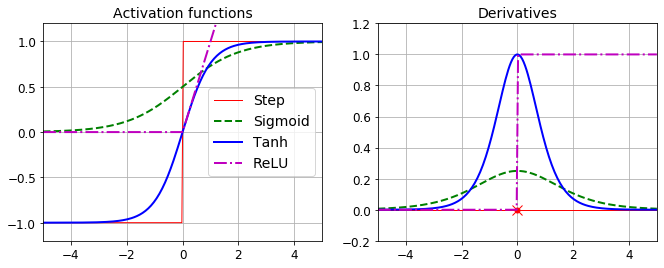

In [12]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

# save_fig("activation_functions_plot")
plt.show()

In [0]:
def heaviside(z):
  return (z>=0).astype(z.dtype)

def mlp_xor(x1,x2, activation=heaviside):
  return activation(-activation(x1+x2-1.5)+activation(x1+x2-0.5)-0.5)

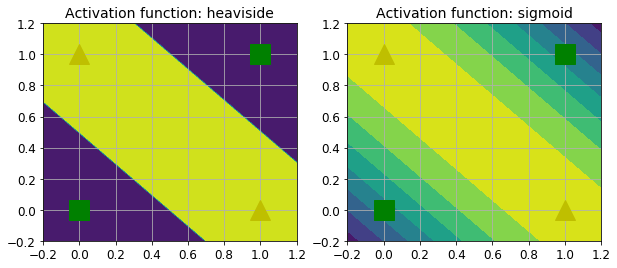

In [14]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

FNN for MNIST

Using the Estimator API (formerly tf.contrib.learn)

In [15]:
import tensorflow as tf

In [17]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1,28*28)/255.0
X_test = X_test.astype(np.float32).reshape(-1,28*28)/255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train  = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

11493376/11490434 [==============================] - 0s 0us/step


In [21]:
feature_cols = [tf.feature_column.numeric_column("X",shape=[28*28])]
dnn_clf = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                     feature_columns= feature_cols)
input_fn = tf.estimator.inputs.numpy_input_fn(x={"X":X_train}, y=y_train, num_epochs=40, 
                                                 batch_size=50, shuffle=True)
dnn_clf.train(input_fn=input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp88zulb9x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9b87ddd860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Use Variable.read_value. Vari

In [22]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X":X_test}, y=y_test, shuffle=False)
eval_results= dnn_clf.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-21T01:58:00Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp88zulb9x/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-21-01:58:00
INFO:tensorflow:Saving dict for global step 44000: accuracy = 0.9807, average_loss = 0.09927771, global_step = 44000, loss = 12.566799
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 44000: /tmp/tmp88zulb9x/model.ckpt-44000


In [23]:
eval_results

{'accuracy': 0.9807,
 'average_loss': 0.09927771,
 'global_step': 44000,
 'loss': 12.566799}

In [25]:
y_pred_iter = dnn_clf.predict(input_fn=test_input_fn)
y_pred=list(y_pred_iter)
y_pred[0]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp88zulb9x/model.ckpt-44000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


{'all_class_ids': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 'all_classes': array([b'0', b'1', b'2', b'3', b'4', b'5', b'6', b'7', b'8', b'9'],
       dtype=object),
 'class_ids': array([7]),
 'classes': array([b'7'], dtype=object),
 'logits': array([ -3.4191854 ,   0.03407572,  -3.4285192 ,   6.8053493 ,
         -4.448294  ,  -4.9567866 , -13.072114  ,  20.311287  ,
         -5.1945004 ,   1.8349665 ], dtype=float32),
 'probabilities': array([4.9429492e-11, 1.5621334e-09, 4.8970238e-11, 1.3628412e-06,
        1.7662422e-11, 1.0622197e-11, 3.1752144e-15, 9.9999869e-01,
        8.3748486e-12, 9.4587884e-09], dtype=float32)}

Using plain TensorFlow

In [0]:
import tensorflow as tf

n_inputs = 28*28 # mnist
n_hidden1=300
n_hidden2=100
n_outputs=10

In [0]:
reset_graph()

X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y=tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
def neuron_layer(X, n_neurons, name, activation=None):
  with tf.name_scope(name):
    n_inputs = int(X.get_shape()[1])
    stddev=2/np.sqrt(n_inputs)
    init=tf.truncated_normal((n_inputs, n_neurons),stddev=stddev)
    W=tf.Variable(init, name="kernel")
    b=tf.Variable(tf.zeros([n_neurons]), name="bias")
    Z = tf.matmul(X,W)+b
    if activation is not None:
      return activation(Z)
    else:
      return Z

In [0]:
with tf.name_scope("dnn"):
  hidden1=neuron_layer(X,n_hidden1,name="hidden1",
                       activation = tf.nn.relu)
  hidden2=neuron_layer(hidden1, n_hidden2, name="hidden2",
                       activation=tf.nn.relu)
  logits=neuron_layer(hidden2, n_outputs,name="outputs")

In [0]:
with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
  loss=tf.reduce_mean(xentropy, name="loss")

In [0]:
learning_rate = 0.01

with tf.name_scope("train"):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  training_op = optimizer.minimize(loss)

In [0]:
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits,y,1)
  accuracy = tf.reduce_mean(tf.cast(correct,tf.float32))

In [0]:
init=tf.global_variables_initializer()
saver = tf.train.Saver()

In [0]:
n_epochs=40
batch_size=50

In [0]:
def shuffle_batch(X,y,batch_size):
  rnd_idx=np.random.permutation(len(X))
  n_batches = len(X)//batch_size
  for batch_idx in np.array_split(rnd_idx, n_batches):
    X_batch, y_batch= X[batch_idx], y[batch_idx]
    yield X_batch, y_batch

In [38]:
with tf.Session() as sess:
  init.run()

  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
    acc_val = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
    print(epoch, "Batch accuracy:", acc_batch, "Val accuracy:", acc_val)

  save_path = saver.save(sess, "./my_model_final.ckpt")

0 Batch accuracy: 0.9 Val accuracy: 0.9146
1 Batch accuracy: 0.92 Val accuracy: 0.936
2 Batch accuracy: 0.96 Val accuracy: 0.945
3 Batch accuracy: 0.92 Val accuracy: 0.9514
4 Batch accuracy: 0.98 Val accuracy: 0.956
5 Batch accuracy: 0.96 Val accuracy: 0.9566
6 Batch accuracy: 1.0 Val accuracy: 0.9612
7 Batch accuracy: 0.94 Val accuracy: 0.9632
8 Batch accuracy: 0.98 Val accuracy: 0.965
9 Batch accuracy: 0.96 Val accuracy: 0.9662
10 Batch accuracy: 0.92 Val accuracy: 0.9686
11 Batch accuracy: 0.98 Val accuracy: 0.9686
12 Batch accuracy: 0.98 Val accuracy: 0.9672
13 Batch accuracy: 0.98 Val accuracy: 0.9708
14 Batch accuracy: 1.0 Val accuracy: 0.9714
15 Batch accuracy: 0.94 Val accuracy: 0.9732
16 Batch accuracy: 1.0 Val accuracy: 0.973
17 Batch accuracy: 1.0 Val accuracy: 0.974
18 Batch accuracy: 1.0 Val accuracy: 0.9748
19 Batch accuracy: 0.98 Val accuracy: 0.9744
20 Batch accuracy: 1.0 Val accuracy: 0.975
21 Batch accuracy: 1.0 Val accuracy: 0.9756
22 Batch accuracy: 0.98 Val accurac

In [39]:
with tf.Session() as sess:
  saver.restore(sess, "./my_model_final.ckpt")
  X_new_scaled = X_test[:20]
  Z = logits.eval(feed_dict={X:X_new_scaled})
  y_pred = np.argmax(Z, axis=1)

INFO:tensorflow:Restoring parameters from ./my_model_final.ckpt


In [40]:
print("Predicted class:", y_pred)
print("Actual class:", y_test[:20])

Predicted class: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
Actual class: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]


Using dense() instead of neuron_layer()


Note: previous releases of the book used tensorflow.contrib.layers.fully_connected() rather than tf.layers.dense() (which did not exist when this chapter was written). It is now preferable to use tf.layers.dense(), because anything in the contrib module may change or be deleted without notice. The dense() function is almost identical to the fully_connected() function, except for a few minor differences:





several parameters are renamed: scope becomes name, activation_fn becomes activation (and similarly the _fn suffix is removed from other parameters such as normalizer_fn), weights_initializer becomes kernel_initializer, etc.

the default activation is now None rather than tf.nn.relu.

a few more differences are presented in chapter 11.

In [0]:
n_inputs= 28*28 # mnist
n_hidden1=300
n_hidden2=100
n_outputs = 10

In [0]:
reset_graph()

X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y=tf.placeholder(tf.int32, shape=(None), name="y")

In [43]:
with tf.name_scope("dnn"):
  hidden1 = tf.layers.dense(X, n_hidden1, name="hidden_1", activation=tf.nn.relu)
  hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden_2", activation=tf.nn.relu)
  logits=tf.layers.dense(hidden2, n_outputs, name="outputs")
  y_proba = tf.nn.softmax(logits)

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  loss = tf.reduce_mean(xentropy, name="loss")

In [0]:
learning_rate=0.01

with tf.name_scope("train"):
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  training_op = optimizer.minimize(loss)

In [0]:
with tf.name_scope("eval"):
  correct = tf.nn.in_top_k(logits, y,1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [0]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [49]:
n_epochs=20
n_batches=50

with tf.Session() as sess:
  init.run()

  for epoch in range(n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    acc_batch = accuracy.eval(feed_dict={X:X_batch, y:y_batch})
    acc_valid = accuracy.eval(feed_dict={X:X_valid, y:y_valid})
    print("epoch:", epoch, "Batch accuracy:",acc_batch, "Val accuracy:", acc_val)

  save_path = saver.save(sess, "./my_model_final.ckpt")

epoch: 0 Batch accuracy: 0.94 Val accuracy: 0.9776
epoch: 1 Batch accuracy: 0.94 Val accuracy: 0.9776
epoch: 2 Batch accuracy: 0.9 Val accuracy: 0.9776
epoch: 3 Batch accuracy: 0.94 Val accuracy: 0.9776
epoch: 4 Batch accuracy: 0.94 Val accuracy: 0.9776
epoch: 5 Batch accuracy: 1.0 Val accuracy: 0.9776
epoch: 6 Batch accuracy: 0.94 Val accuracy: 0.9776
epoch: 7 Batch accuracy: 0.96 Val accuracy: 0.9776
epoch: 8 Batch accuracy: 0.94 Val accuracy: 0.9776
epoch: 9 Batch accuracy: 0.92 Val accuracy: 0.9776
epoch: 10 Batch accuracy: 0.98 Val accuracy: 0.9776
epoch: 11 Batch accuracy: 0.98 Val accuracy: 0.9776
epoch: 12 Batch accuracy: 0.98 Val accuracy: 0.9776
epoch: 13 Batch accuracy: 1.0 Val accuracy: 0.9776
epoch: 14 Batch accuracy: 0.94 Val accuracy: 0.9776
epoch: 15 Batch accuracy: 0.98 Val accuracy: 0.9776
epoch: 16 Batch accuracy: 1.0 Val accuracy: 0.9776
epoch: 17 Batch accuracy: 0.98 Val accuracy: 0.9776
epoch: 18 Batch accuracy: 0.96 Val accuracy: 0.9776
epoch: 19 Batch accuracy: 

Exercise solutions

Train a deep MLP on the MNIST dataset and see if you can get over 98% precision. Just like in the last exercise of chapter 9, try adding all the bells and whistles (i.e., save checkpoints, restore the last checkpoint in case of an interruption, add summaries, plot learning curves using TensorBoard, and so on).

First let's create the deep net. It's exactly the same as earlier, with just one addition: we add a tf.summary.scalar() to track the loss and the accuracy during training, so we can view nice learning curves using TensorBoard.

In [0]:
n_inputs = 28*28 #mnist
n_hidden1=300
n_hidden2=100
n_outputs=10

In [0]:
reset_graph()

X=tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y=tf.placeholder(tf.int32, shape=(None), name="y")

In [0]:
with tf.name_scope("dnn"):
  hidden1= tf.layers.dense(X, n_hidden1, name="hidden1", activation=tf.nn.relu)
  hidden2=tf.layers.dense(hidden1, n_hidden2, name="hidden2", activation=tf.nn.relu)
  logits = tf.layers.dense(hidden2, n_outputs, name="output")

In [54]:
with tf.name_scope("loss"):
  xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
  loss=tf.reduce_mean(xentropy)
  loss_summary=tf.summary.scalar("log loss", loss)

INFO:tensorflow:Summary name log loss is illegal; using log_loss instead.


In [0]:
learning_rate=0.01

with tf.name_scope("train"):
  optimizer =tf.train.GradientDescentOptimizer(learning_rate)
  training_op= optimizer.minimize(loss)

In [0]:
with tf.name_scope("eval"):
  correct =tf.nn.in_top_k(logits, y,1)
  accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
  accuracy_summary= tf.summary.scalar("accuracy", accuracy)

In [0]:
init =tf.global_variables_initializer()
saver=tf.train.Saver()

Now we need to define the directory to write the TensorBoard logs to:



In [0]:
from datetime import datetime

def log_dir(prefix=""):
  now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
  root_logdir="tf_logs"
  if prefix:
    prefix += "-"
  name = prefix + "run-"+now
  return "{}/{}/".format(root_logdir, name)

In [0]:
logdir = log_dir("mnist_dnn")

Now we can create the FileWriter that we will use to write the TensorBoard logs:



In [0]:
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

Hey! Why don't we implement early stopping? For this, we are going to need to use the validation set.



In [0]:
m,n=X_train.shape

In [66]:
n_epochs=10001
batch_size=50
n_batches= int(np.ceil(m/batch_size))

checkpoint_path = "/tmp/my_deep_mnist_model.ckpt"
checkpoint_epoch_path = checkpoint_path + ".epoch"
final_model_path = "./my_deep_mnist_model"

best_loss = np.infty
epochs_without_progress=0
max_epochs_without_progress=50

with tf.Session() as sess:
  if os.path.isfile(checkpoint_epoch_path):
    # if the checkpoint file exists, restore the model and load the epoch number
    with open(checkpoint_epoch_path,"rb") as f:
      start_epoch=int(f.read())
    print("training was interrrupted, continuing at epoch", start_epoch)
    saver.restore(sess, checkpoint_path)

  else:
    start_epoch=0
    sess.run(init)

  for epoch in range(start_epoch, n_epochs):
    for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
      sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
    accuracy_val, loss_val, accuracy_summary_str, loss_summary_str = sess.run(
        [accuracy, loss, accuracy_summary, loss_summary], feed_dict={X:X_valid, y:y_valid}
    )

    file_writer.add_summary(accuracy_summary_str, epoch)
    file_writer.add_summary(loss_summary_str, epoch)
    if epoch%5==0:
      print("epoch:", epoch, "val accuracy:", accuracy_val*100, "loss:", loss_val)
      saver.save(sess, checkpoint_path)
      with open(checkpoint_epoch_path, "wb") as f:
        f.write(b"%d"%(epoch+1))
      if loss_val<best_loss:
        saver.save(sess, final_model_path)
        best_loss = loss_val
      else:
        epochs_without_progress +=5
        if epochs_without_progress > max_epochs_without_progress:
          print("early stopping")
          break

epoch: 0 val accuracy: 90.20000100135803 loss: 0.35498813
epoch: 5 val accuracy: 95.09999752044678 loss: 0.17518954
epoch: 10 val accuracy: 96.70000076293945 loss: 0.12527336
epoch: 15 val accuracy: 97.18000292778015 loss: 0.104002535
epoch: 20 val accuracy: 97.46000170707703 loss: 0.0916198
epoch: 25 val accuracy: 97.61999845504761 loss: 0.08382479
epoch: 30 val accuracy: 97.71999716758728 loss: 0.075975604
epoch: 35 val accuracy: 97.78000116348267 loss: 0.073199205
epoch: 40 val accuracy: 97.89999723434448 loss: 0.06978728
epoch: 45 val accuracy: 97.87999987602234 loss: 0.069676846
epoch: 50 val accuracy: 98.0400025844574 loss: 0.06623281
epoch: 55 val accuracy: 98.0400025844574 loss: 0.06568668
epoch: 60 val accuracy: 98.14000129699707 loss: 0.06641677
epoch: 65 val accuracy: 98.15999865531921 loss: 0.065890074
epoch: 70 val accuracy: 98.14000129699707 loss: 0.06596501
epoch: 75 val accuracy: 98.18000197410583 loss: 0.06590006
epoch: 80 val accuracy: 98.15999865531921 loss: 0.066002

In [0]:
os.remove(checkpoint_epoch_path)

In [64]:
with tf.Session() as sess:
  saver.restore(sess, final_model_path)
  accuracy_val = accuracy.eval(feed_dict={X:X_test, y:y_test})

INFO:tensorflow:Restoring parameters from ./my_deep_mnist_model


In [65]:
accuracy_val

0.9773